# **Lung Cancer Detection using Custom CNN and PreTrained Swin Transformer**

# **Group Members:**



*   21K-3341 Obaida Naeem
*   21K-3186 Ahsan Ashraf
*   21K-4580 Rahool Rathi



# **Part 1 - Custom CNN**

## **Import Required Libraries**

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout,BatchNormalization, Add, Activation, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## **Loading Dataset**

In [4]:
def load_data(data_dir):
    filepaths, labels = [], []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        for img_file in os.listdir(label_path):
            filepaths.append(os.path.join(label_path, img_file))
            labels.append(label)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

In [5]:
def rename_labels(df):
    rename_dict = {
        'lung_aca': 'Lung_adenocarcinoma',
        'lung_n': 'Lung_benign_tissue',
        'lung_scc': 'Lung_squamous_cell_carcinoma'
    }
    df['labels'] = df['labels'].replace(rename_dict)

In [6]:
# Path to dataset in Colab
data_dir = 'lung_image_sets'
df = load_data(data_dir)
rename_labels(df)

## **Train-Validation-Test Split**

In [7]:
train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42, shuffle=True)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

## **Image Generators**

In [8]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


## **Custom CNN Architecture**

In [9]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [10]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [11]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred

In [12]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [13]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [14]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [15]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [16]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       2

## **Model Training**

In [18]:
epochs = 10
history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10


375/375 [==============================] - 644s 2s/step - loss: 0.4212 - accuracy: 0.8378 - val_loss: 3.4529 - val_accuracy: 0.3360
Epoch 2/10
375/375 [==============================] - 554s 1s/step - loss: 0.2161 - accuracy: 0.9239 - val_loss: 0.2100 - val_accuracy: 0.9320
Epoch 3/10
375/375 [==============================] - 548s 1s/step - loss: 0.1735 - accuracy: 0.9363 - val_loss: 0.1602 - val_accuracy: 0.9380
Epoch 4/10
375/375 [==============================] - 548s 1s/step - loss: 0.1439 - accuracy: 0.9485 - val_loss: 0.1037 - val_accuracy: 0.9627
Epoch 5/10
375/375 [==============================] - 549s 1s/step - loss: 0.1313 - accuracy: 0.9544 - val_loss: 0.1751 - val_accuracy: 0.9367
Epoch 6/10
375/375 [==============================] - 557s 1s/step - loss: 0.1069 - accuracy: 0.9626 - val_loss: 0.1392 - val_accuracy: 0.9573
Epoch 7/10
375/375 [==============================] - 524s 1s/step - loss: 0.0961 - accuracy: 0.9682 - val_loss: 0.0642 - val_accuracy: 0.97

## **Model Perfomance**

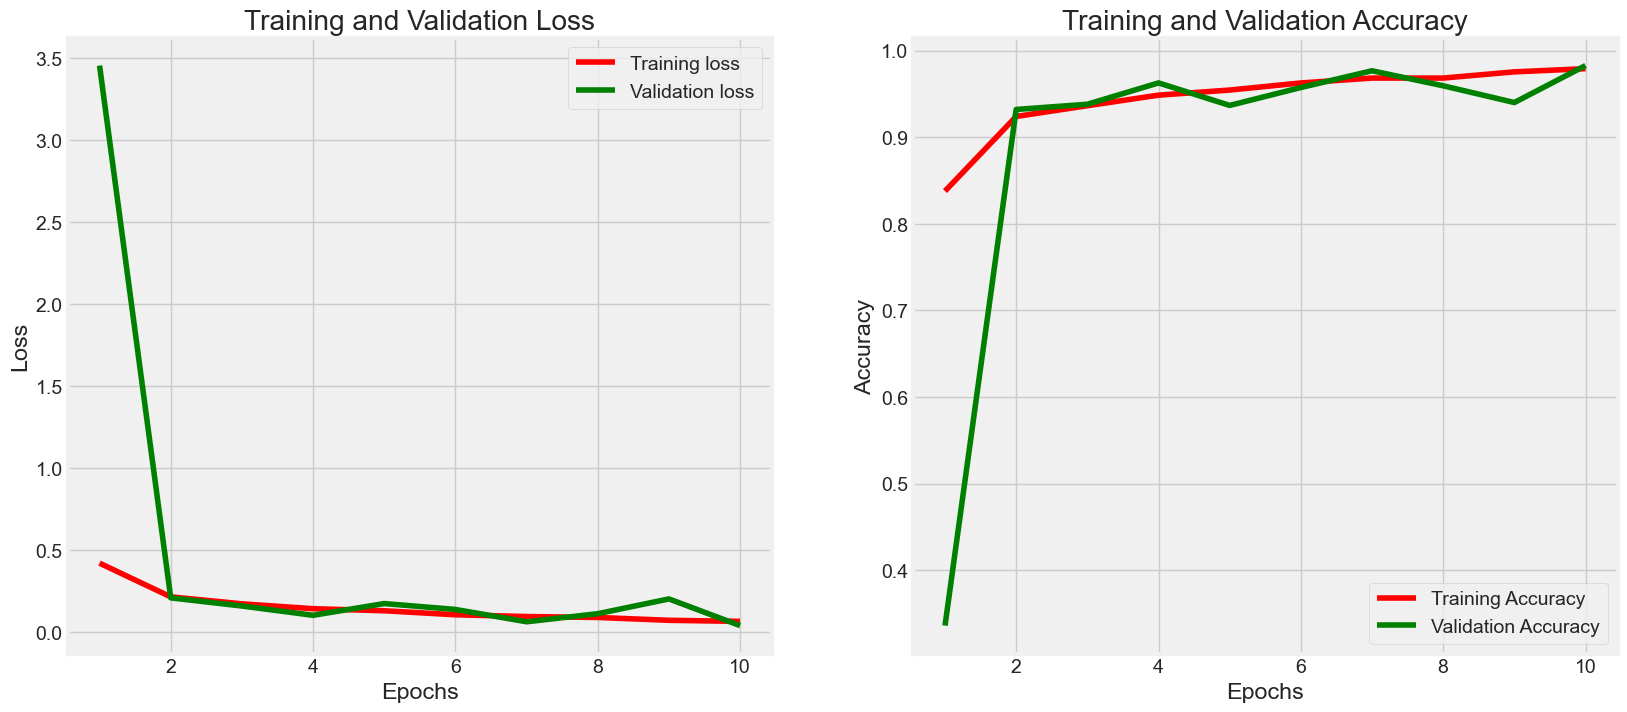

In [19]:
model_performance(history, epochs)

In [20]:
model_evaluation(cnn_model)

47/47 [==============================] - 35s 747ms/step - loss: 0.0288 - accuracy: 0.9893
Train Loss:  0.012846414931118488
Train Accuracy:  0.996666669845581
--------------------
Validation Loss:  0.04097132757306099
Validation Accuracy:  0.9826666712760925
--------------------
Test Loss:  0.028796717524528503
Test Accuracy:  0.9893333315849304


## Get Predictions

In [21]:
y_pred = get_pred(cnn_model, test_gen)

47/47 [==============================] - 15s 314ms/step


In [22]:
def plot_predictions_per_class(model, test_gen, class_names, images_per_class=5):
    # Get predictions and true labels
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes
    filepaths = test_gen.filepaths

    # Reverse class_indices to map label -> class name
    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

    # Organize examples by true class
    class_examples = {cls: [] for cls in range(len(class_names))}
    for i, (pred, true) in enumerate(zip(y_pred, y_true)):
        if len(class_examples[true]) < images_per_class:
            class_examples[true].append((filepaths[i], pred))

        if all(len(lst) == images_per_class for lst in class_examples.values()):
            break

    # Plotting
    plt.figure(figsize=(20, 8))
    for row, (cls, examples) in enumerate(class_examples.items()):
        for col, (img_path, pred_label) in enumerate(examples):
            img = plt.imread(img_path)
            plt.subplot(len(class_names), images_per_class, row * images_per_class + col + 1)
            plt.imshow(img)
            plt.axis('off')
            true_name = class_names[cls]
            pred_name = class_names[pred_label]
            title_color = 'green' if true_name == pred_name else 'red'
            plt.title(f'True: {true_name}\nPred: {pred_name}', color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

47/47 [==============================] - 15s 307ms/step


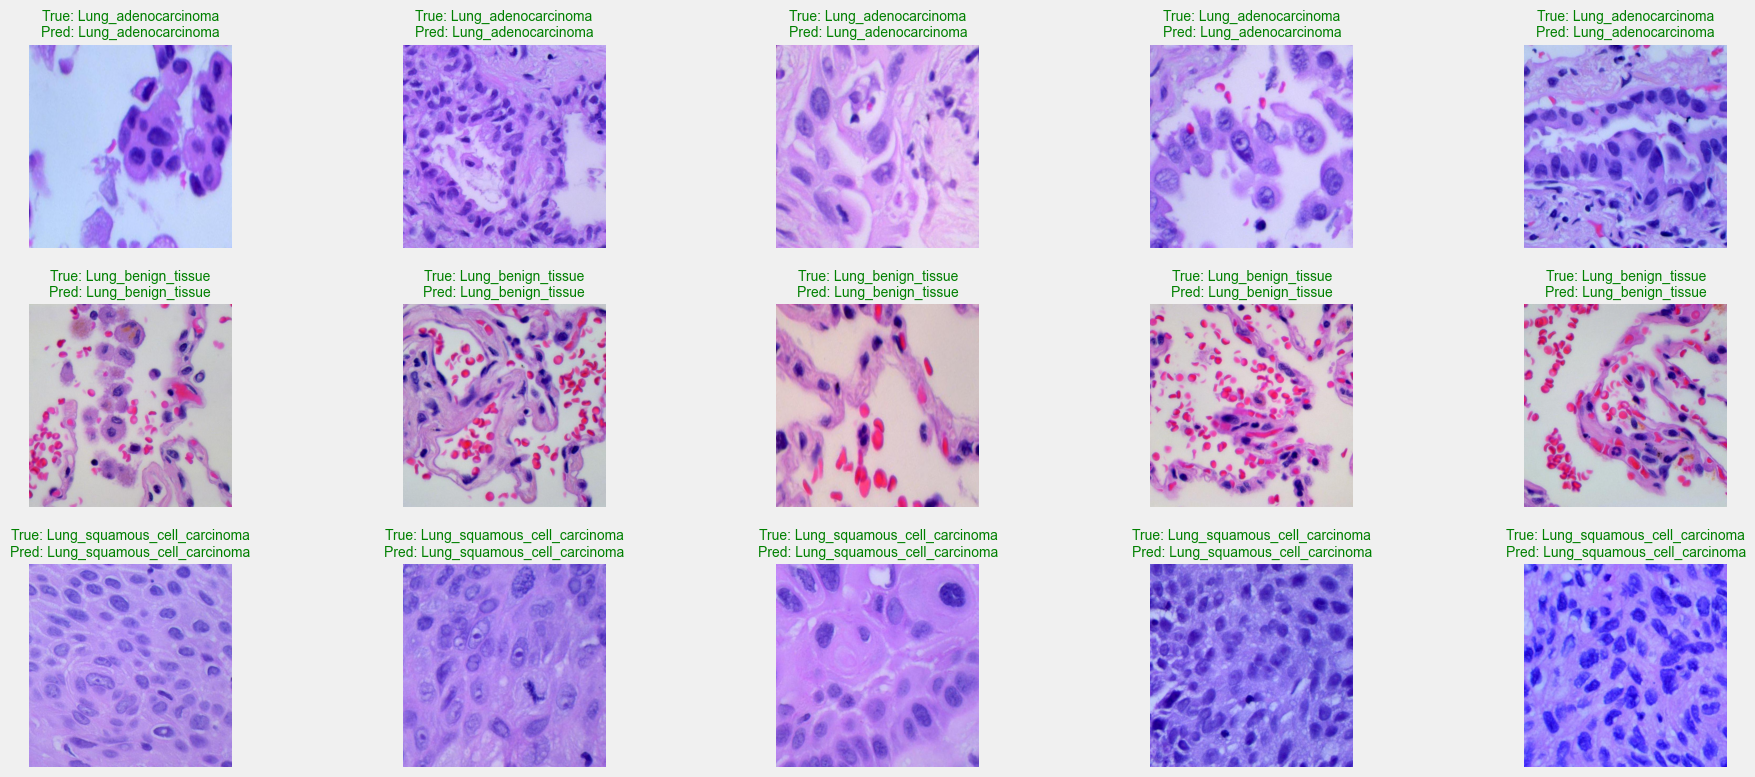

In [25]:
plot_predictions_per_class(cnn_model, test_gen, classes)

## Other Evaluation Metrics

In [26]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_classification_metrics(model, test_gen):
    y_probs = model.predict(test_gen)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # Classification Report (Precision, Recall, F1-score)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # ROC-AUC
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
    try:
        auc = roc_auc_score(y_true_bin, y_probs, multi_class='ovr')
        print(f"ROC-AUC Score (OvR): {auc:.4f}")
    except ValueError:
        print("ROC-AUC could not be computed (possibly due to single-class predictions).")

In [27]:
evaluate_classification_metrics(cnn_model, test_gen)

47/47 [==============================] - 15s 309ms/step
Classification Report:
                              precision    recall  f1-score   support

         Lung_adenocarcinoma       0.99      0.98      0.98       515
          Lung_benign_tissue       1.00      1.00      1.00       493
Lung_squamous_cell_carcinoma       0.98      0.99      0.99       492

                    accuracy                           0.99      1500
                   macro avg       0.99      0.99      0.99      1500
                weighted avg       0.99      0.99      0.99      1500

ROC-AUC Score (OvR): 0.9997


# Part 2 - Pretrained Swin Transformer

## Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [4]:
import timm
from tqdm import tqdm
import time

In [5]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Data Loading and Preprocessing

In [6]:
# Define the dataset directory
data_dir = 'lung_image_sets'

In [7]:
# Create a DataFrame with file paths and labels
def load_data(data_dir):
    filepaths = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        for file in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [8]:
df = load_data(data_dir)

In [9]:
# Rename labels
label_mapping = {
    'lung_aca': 'Lung_adenocarcinoma',
    'lung_n': 'Lung_benign_tissue',
    'lung_scc': 'Lung_squamous_cell_carcinoma'
}
df['labels'] = df['labels'].replace(label_mapping)

In [10]:
# Encode labels
label_to_idx = {label: idx for idx, label in enumerate(df['labels'].unique())}
df['label_idx'] = df['labels'].map(label_to_idx)

In [11]:
# Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

## Custom Dataset Classes

In [12]:
class LungDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df['filepaths'].values
        self.labels = df['label_idx'].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Transforms and Loaders

In [13]:
# Define image size and batch size
img_size = 224
batch_size = 16

In [14]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
# Create datasets
train_dataset = LungDataset(train_df, transform=train_transform)
valid_dataset = LungDataset(valid_df, transform=test_transform)
test_dataset = LungDataset(test_df, transform=test_transform)

In [17]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model: Swin Transformer

In [19]:
# Load a pretrained Swin Transformer model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(label_to_idx))

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

## Model Training

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [22]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    # Wrap the dataloader with tqdm for a progress bar
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch")

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update tqdm with current loss and accuracy
        loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f}s — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch [1/2]: 100%|███████████████████████████████| 750/750 [1:21:22<00:00,  6.51s/batch, accuracy=0.961, loss=0.000592]


Epoch [1/2] completed in 4882.49s — Loss: 0.1040, Accuracy: 0.9611


Epoch [2/2]: 100%|████████████████████████████████| 750/750 [1:43:22<00:00,  8.27s/batch, accuracy=0.984, loss=0.00857]

Epoch [2/2] completed in 6202.31s — Loss: 0.0424, Accuracy: 0.9842


## Model Evaluation

In [23]:
# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [24]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_to_idx.keys()))

Classification Report:
                              precision    recall  f1-score   support

         Lung_adenocarcinoma       1.00      0.98      0.99       500
          Lung_benign_tissue       1.00      1.00      1.00       500
Lung_squamous_cell_carcinoma       0.98      1.00      0.99       500

                    accuracy                           0.99      1500
                   macro avg       0.99      0.99      0.99      1500
                weighted avg       0.99      0.99      0.99      1500



In [26]:
# ROC-AUC Score
# Binarize the labels for ROC-AUC
all_labels_bin = label_binarize(all_labels, classes=list(range(len(label_to_idx))))
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

roc_auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 1.0000


## Visualize Predictions

In [32]:
def display_predictions(model, dataset, label_to_idx):
    model.eval()
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    class_samples = {idx: [] for idx in idx_to_label.keys()}

    with torch.no_grad():
        for img, label in dataset:
            if len(class_samples[label]) < 5:
                input_img = img.unsqueeze(0).to(device)
                output = model(input_img)
                _, pred = torch.max(output, 1)
                class_samples[label].append((img, pred.item()))
            if all(len(samples) == 5 for samples in class_samples.values()):
                break

    # Plotting
    for label_idx, samples in class_samples.items():
        true_label_name = idx_to_label[label_idx]
        plt.figure(figsize=(15, 3))
        for i, (img, pred) in enumerate(samples):
            plt.subplot(1, 5, i + 1)
            img_np = img.permute(1, 2, 0).numpy()
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            plt.imshow(img_np)
            pred_label_name = idx_to_label[pred]
            plt.title(f'True: {true_label_name}\nPred: {pred_label_name}', fontsize=10)
            plt.axis('off')
        plt.suptitle(f'Class: {true_label_name}', fontsize=14)
        plt.tight_layout()
        plt.show()

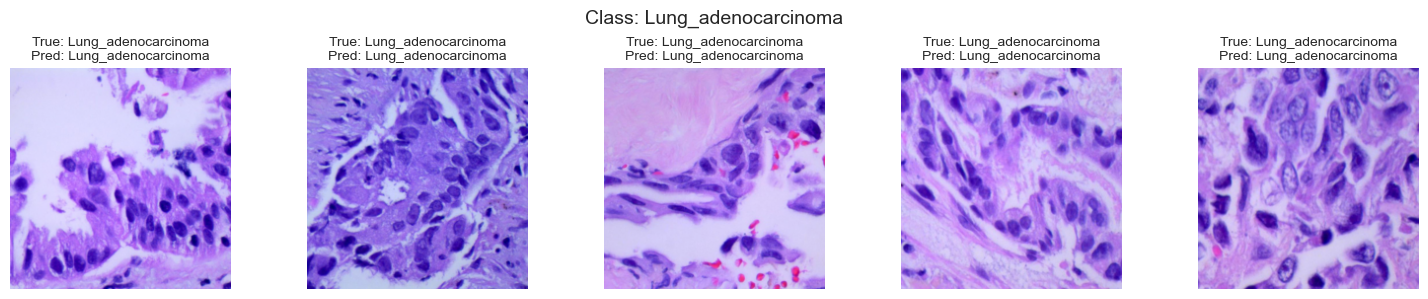

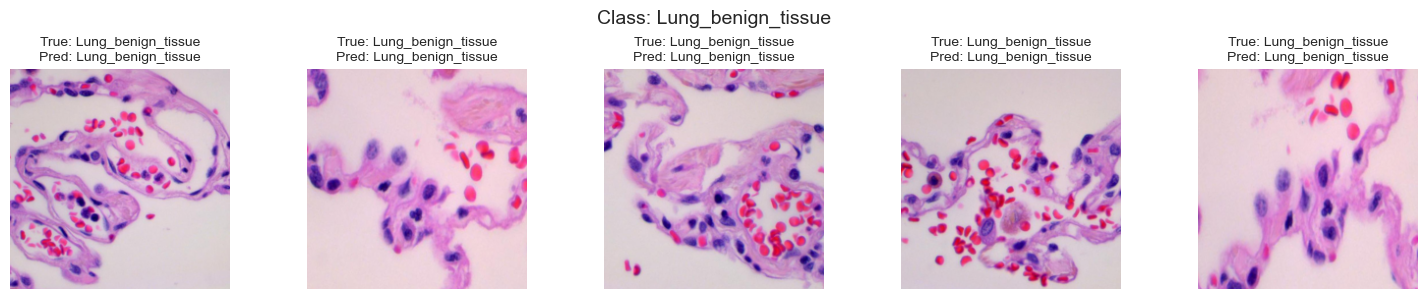

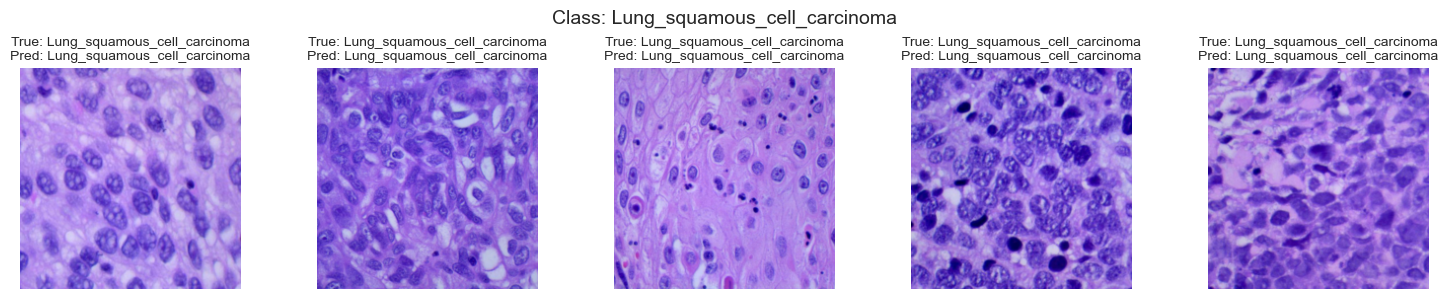

In [33]:
display_predictions(model, test_dataset, label_to_idx)